Prepare the Notebook

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.prior import Prior

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

Generate Date
1. Data Range: We consider a data range of 4 years, weekly granularity.

In [3]:
#Parameters
seed: int = 300
rng: np.random.Generator = np.random.default_rng(seed=seed)

start_date=pd.to_datetime("2021-01-01")
end_date=pd.to_datetime("2024-12-31")

channels = ["ooh", "tv", "print", "facebook", "search"]

In [4]:
date_range=pd.date_range(start=start_date, end=end_date, freq='W-MON')
df=pd.DataFrame( {'date':date_range}).assign(    
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    week=lambda x: x["date"].dt.isocalendar().week,
    dayofyear=lambda x: x["date"].dt.dayofyear,)

In [5]:
n=df.shape[0] # Number of observations 
n

209

2. Trend and Seasonality

[Text(0.5, 1.0, 'Trend & Seasonality Components'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, '')]

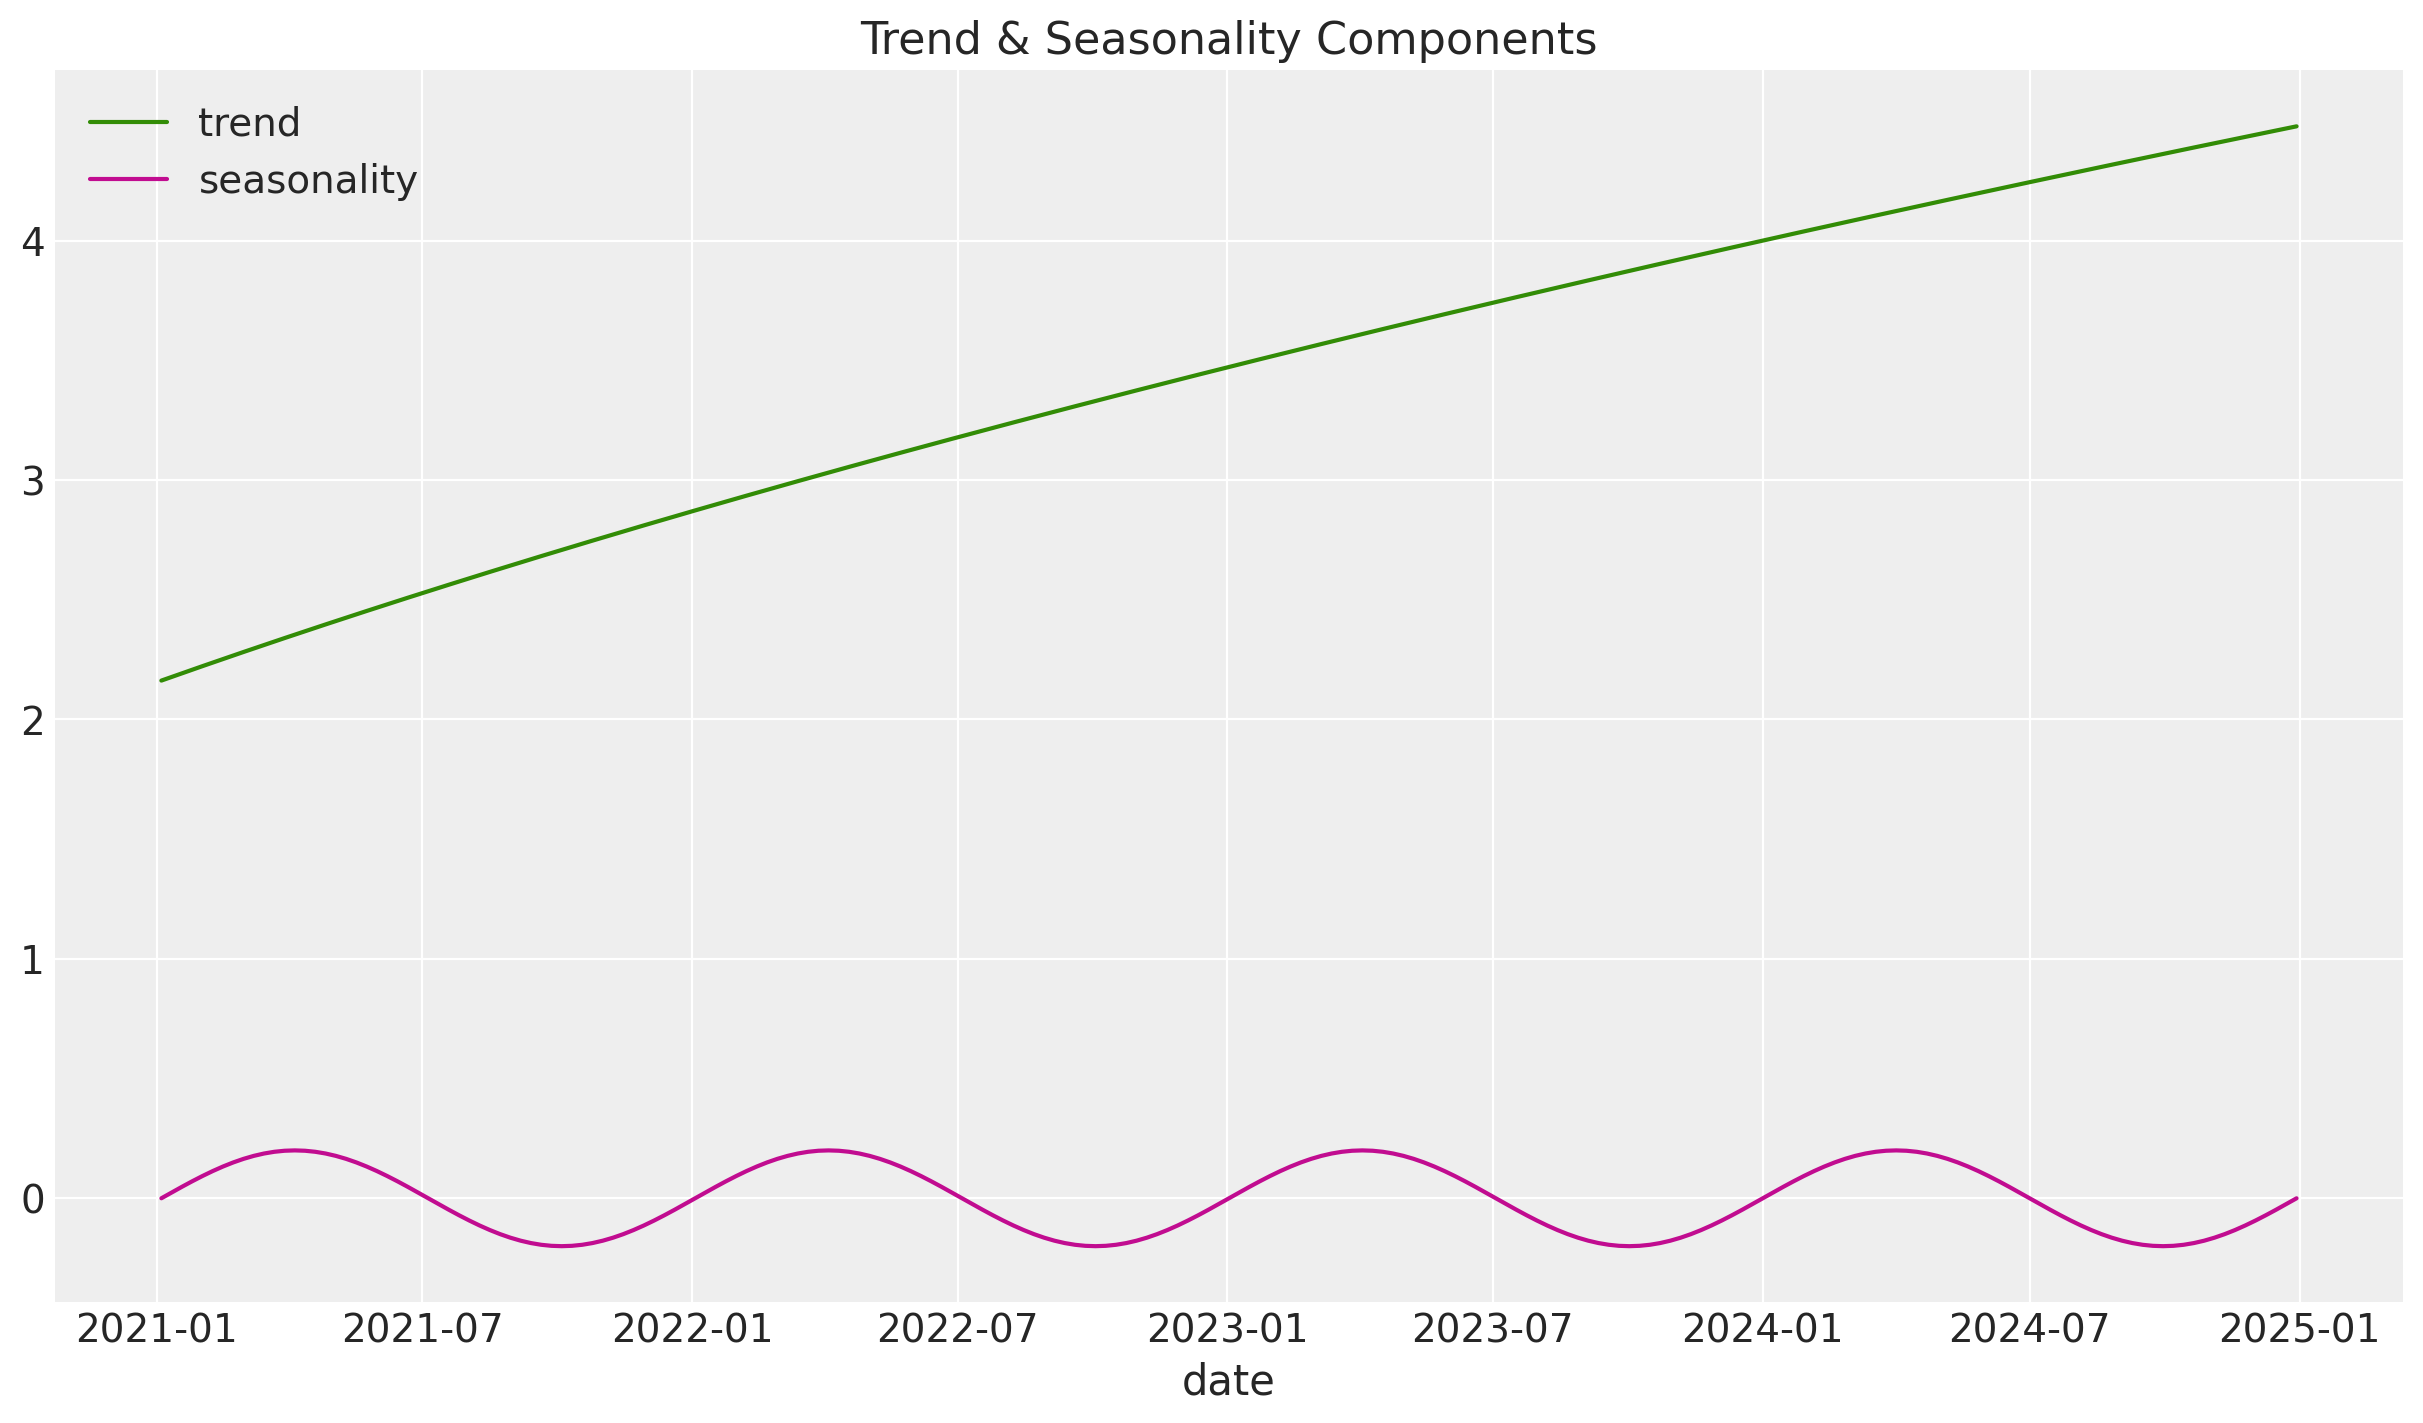

In [6]:
#trend component with some growth
df["trend"]= (np.linspace(0,20,n)+10)**(1/2)-1
#seasonal component oscillation around 0
df["seasonality"] = 0.2 * np.sin(2 * np.pi * df.index / 52)
    
fig,ax=plt.subplots()
sns.lineplot(x="date", y="trend", color="C2", label="trend", data=df,ax=ax)
sns.lineplot(x="date", y="seasonality", color="C3", label="seasonality", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None)

3. A proxy for demand

[Text(0.5, 1.0, 'Components'), Text(0.5, 0, 'date'), Text(0, 0.5, '')]

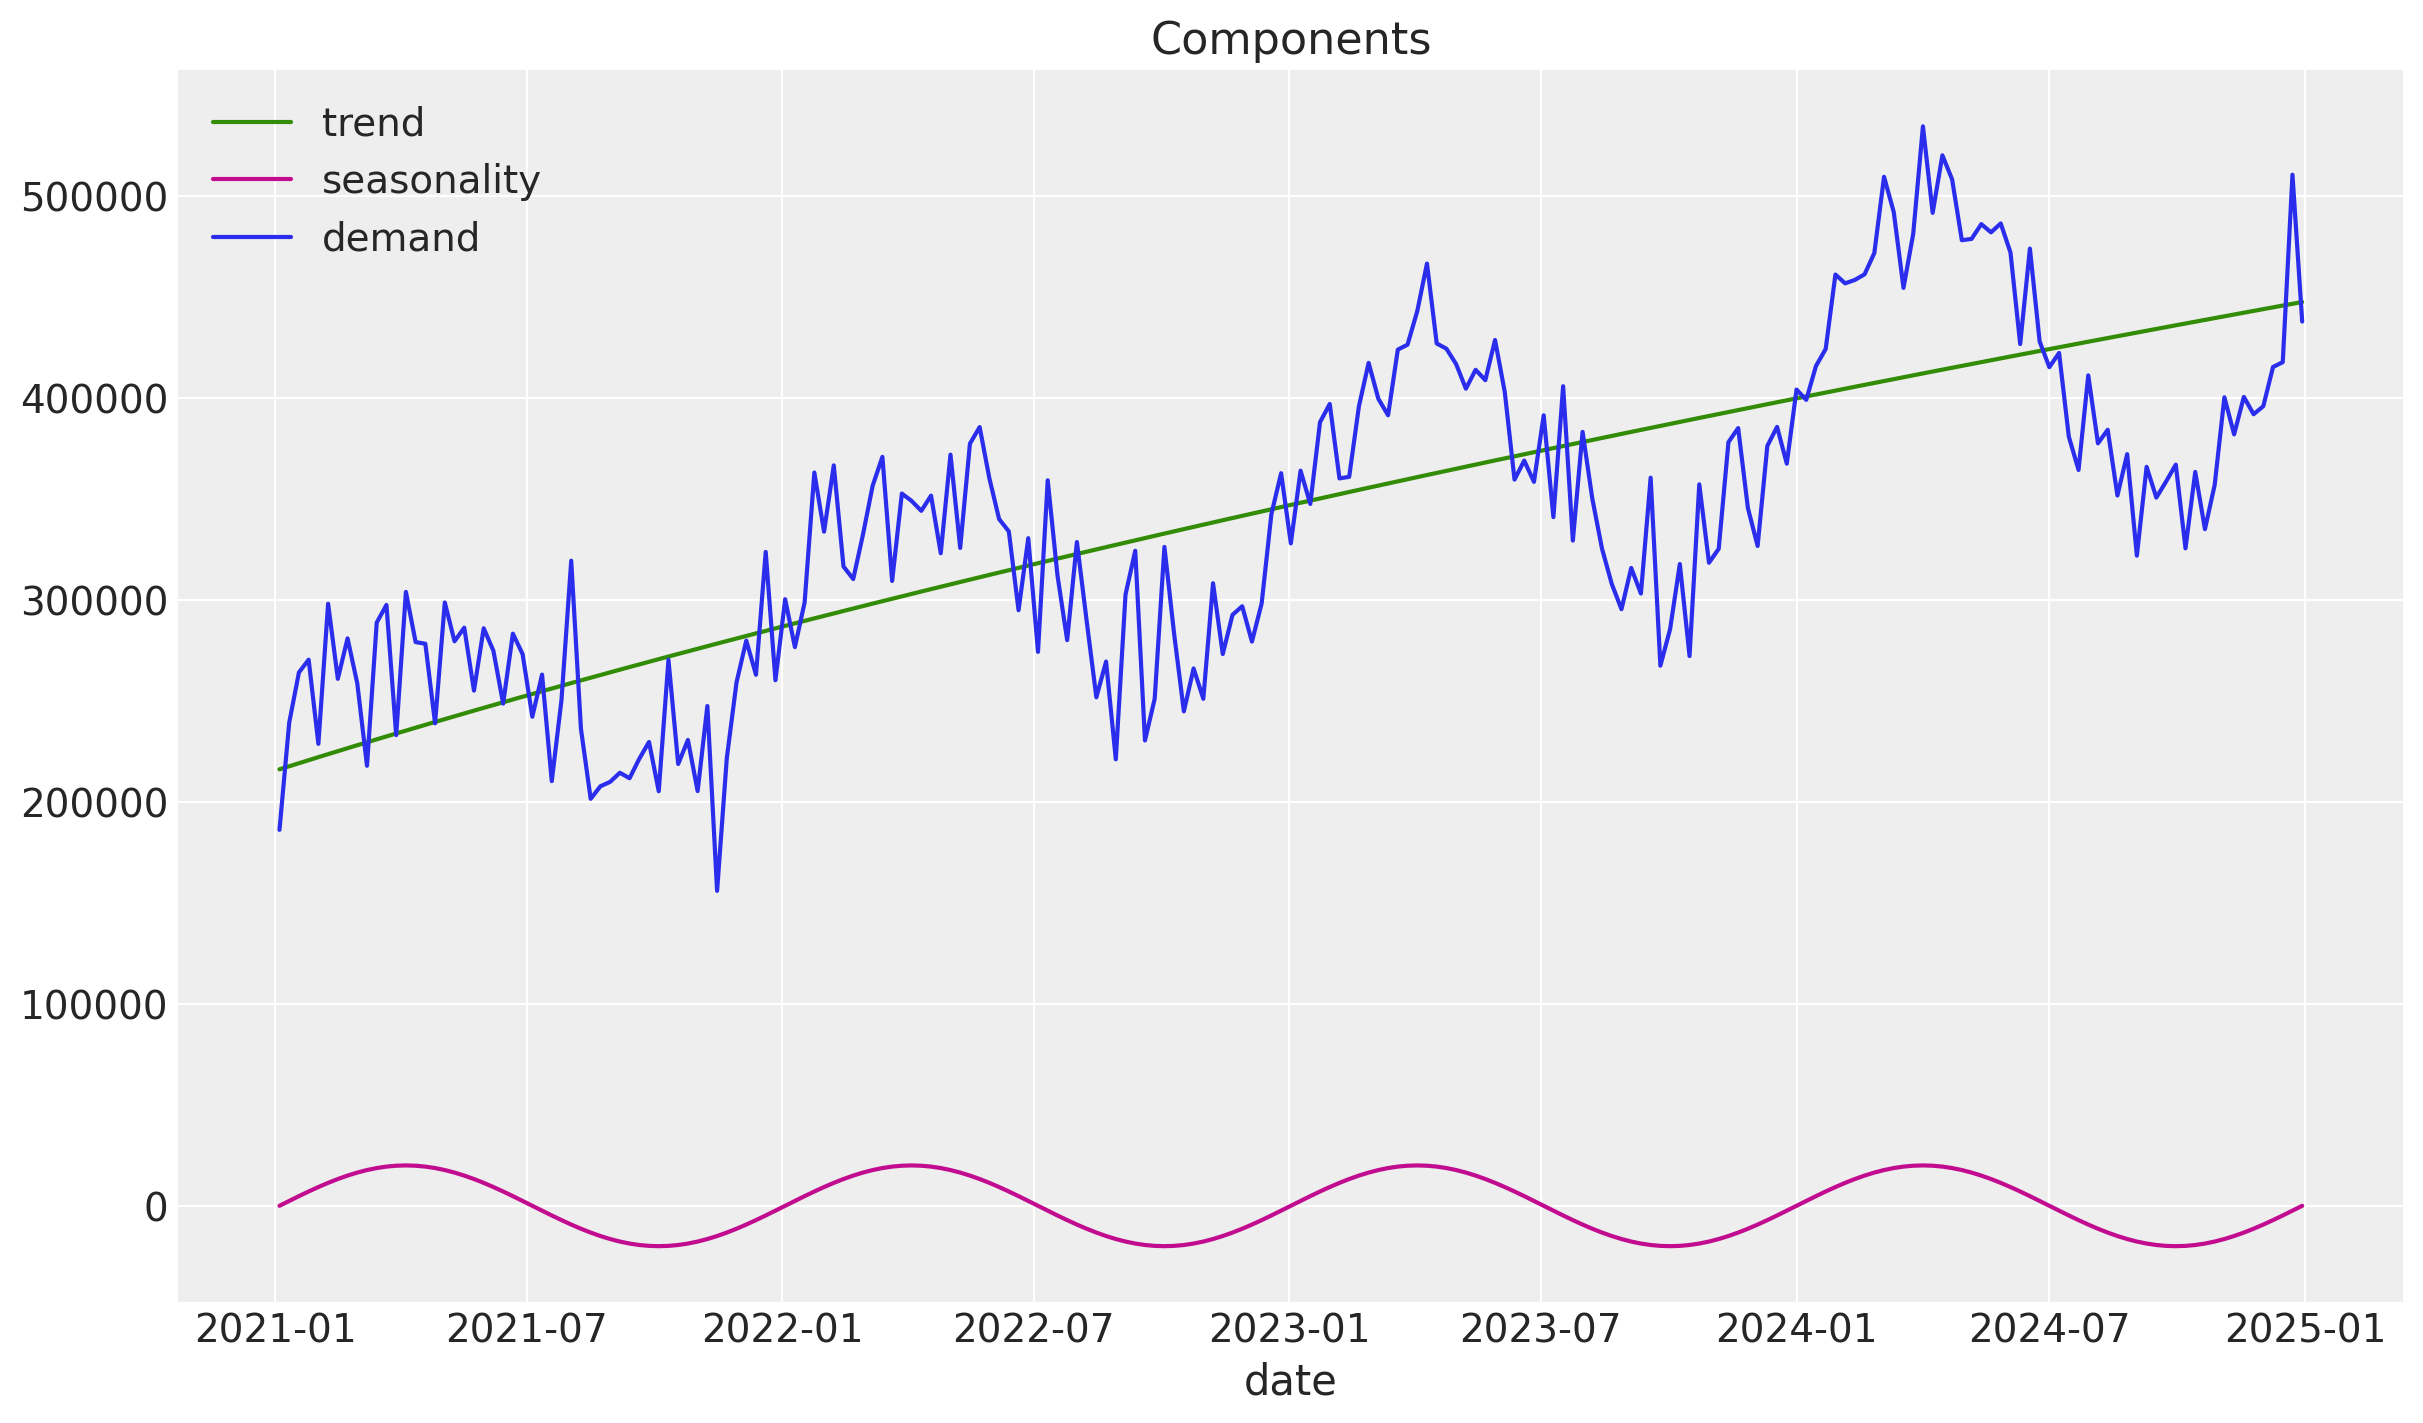

In [7]:
 # Multiply trend and seasonality to create overall demand with noise
df["demand"] = df["trend"] * (1 + df["seasonality"]) + np.random.normal(loc=0, scale=0.25, size=n)
df["demand"] = df["demand"] * 100000 # Scale demand to a reasonable level
    
#Create proxy for demand, which is able to follow demand but has some noise added
df["demand_proxy"] = np.abs(df["demand"]* np.random.normal(loc=1, scale=0.10, size=n))


fig,ax=plt.subplots()
sns.lineplot(x="date", y=df["trend"]*100000, color="C2", label="trend", data=df,ax=ax)
sns.lineplot(x="date", y=df["seasonality"]*100000, color="C3", label="seasonality", data=df, ax=ax)
sns.lineplot(x="date", y="demand", label="demand", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Components", xlabel="date", ylabel=None)

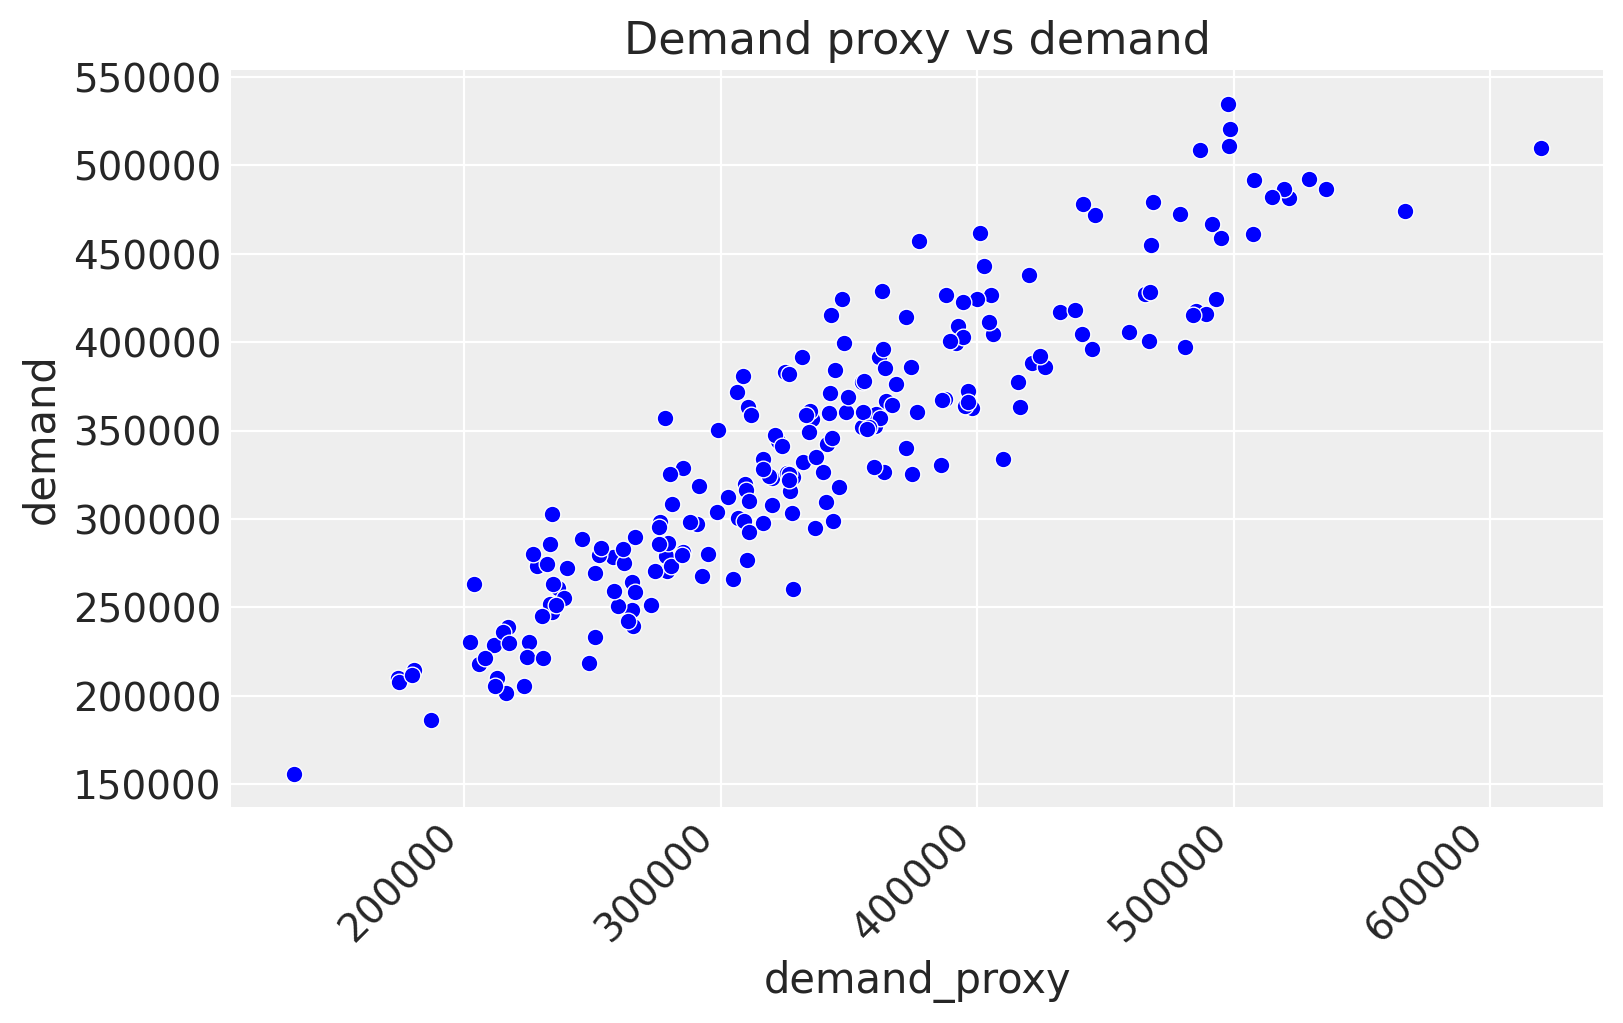

In [8]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x=df['demand_proxy'], y=df['demand'], color="blue")
plt.title('Demand proxy vs demand', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

4. Channel-specific spend

In [9]:
def generate_spend_from_demand(df, rng, spend_scalar=None):
    """
    Generates realistic media spend signals based on a simulated demand series.

    Parameters:
        df : pandas DataFrame containing a 'demand' column
        rng : np.random.Generator instance (e.g., np.random.default_rng(seed))
        spend_scalar : dict of scalar multipliers for each channel (optional, defaults provided)

    Returns:
        df : DataFrame enriched with '{channel}_spend_raw' columns
    """

    # Default scalars if not provided
    if spend_scalar is None:
        spend_scalar = {
            "tv": 0.015,
            "ooh": 0.004,
            "print": 0.001,
            "facebook": 0.012,
            "search": 0.006
        }

    n = len(df)

    for channel, scalar in spend_scalar.items():
        base_spend = df["demand"] * scalar

        if channel == "tv":
            # TV: high budget, bursty campaigns
            mask = rng.uniform(0, 1, n) > 0.85  # active ~15% of time
            spend = np.where(mask, base_spend * rng.normal(1.0, 0.3, n), 0)

        elif channel == "ooh":
            # Out-of-home: relatively consistent with moderate noise
            spend = base_spend * rng.normal(1.0, 0.15, n)

        elif channel == "print":
            # Print: rarely used, highly variable when active
            mask = rng.uniform(0, 1, n) > 0.9  # active ~10% of time
            spend = np.where(mask, base_spend * rng.normal(1.0, 0.4, n), 0)

        elif channel == "facebook":
            # Facebook: always-on, but noisy due to algorithmic bidding
            spend = base_spend * rng.normal(1.0, 0.25, n)

        elif channel == "search":
            # Search: very stable, performance-driven
            spend = base_spend * rng.normal(1.0, 0.1, n)

        else:
            # Fallback: moderate noise
            spend = base_spend * rng.normal(1.0, 0.2, n)

        # Clip to avoid negative spend values
        df[f"{channel}_spend_raw"] = np.clip(spend, 0, None)

    return df


In [10]:
df

,date,year,month,week,dayofyear,trend,seasonality,demand,demand_proxy
0,2021-01-04,2021,1,1,4,2.162278,0.000000e+00,186227.446914,186878.422389
1,2021-01-11,2021,1,2,11,2.177445,2.410734e-02,239311.922323,265956.511598
2,2021-01-18,2021,1,3,18,2.192539,4.786313e-02,264222.282982,265447.857271
3,2021-01-25,2021,1,4,25,2.207563,7.092098e-02,270541.518018,279084.357704
4,2021-02-01,2021,2,5,32,2.222517,9.294463e-02,228844.117733,211587.165602
...,...,...,...,...,...,...,...,...,...
204,2024-12-02,2024,12,49,337,4.442002,-9.294463e-02,396097.736440,363346.275875
205,2024-12-09,2024,12,50,344,4.450829,-7.092098e-02,415529.404733,484228.336197
206,2024-12-16,2024,12,51,351,4.459642,-4.786313e-02,417926.015750,437950.225209
207,2024-12-23,2024,12,52,358,4.468441,-2.410734e-02,510778.369812,498193.552635


In [11]:
df=generate_spend_from_demand(df,rng)

In [12]:
from sklearn.preprocessing import MaxAbsScaler

for channel in ["tv", "ooh", "print", "facebook", "search"]:
    raw = df[f"{channel}_spend_raw"].values.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(raw)
    df[f"{channel}_spend"] = scaler.transform(raw).flatten()
df

,date,year,month,week,dayofyear,trend,seasonality,demand,demand_proxy,tv_spend_raw,ooh_spend_raw,print_spend_raw,facebook_spend_raw,search_spend_raw,tv_spend,ooh_spend,print_spend,facebook_spend,search_spend
0,2021-01-04,2021,1,1,4,2.162278,0.000000e+00,186227.446914,186878.422389,0.0,812.021456,0.000000,2291.791496,1121.400845,0.0,0.354888,0.000000,0.243246,0.325943
1,2021-01-11,2021,1,2,11,2.177445,2.410734e-02,239311.922323,265956.511598,0.0,1080.082931,0.000000,2263.824832,1434.227780,0.0,0.472042,0.000000,0.240277,0.416868
2,2021-01-18,2021,1,3,18,2.192539,4.786313e-02,264222.282982,265447.857271,0.0,877.748372,0.000000,2996.435315,1379.515127,0.0,0.383613,0.000000,0.318035,0.400965
3,2021-01-25,2021,1,4,25,2.207563,7.092098e-02,270541.518018,279084.357704,0.0,827.463404,0.000000,3926.189637,1610.795566,0.0,0.361636,0.000000,0.416717,0.468188
4,2021-02-01,2021,2,5,32,2.222517,9.294463e-02,228844.117733,211587.165602,0.0,941.630195,0.000000,2684.968450,1271.449596,0.0,0.411532,0.000000,0.284976,0.369555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2024-12-02,2024,12,49,337,4.442002,-9.294463e-02,396097.736440,363346.275875,0.0,1168.798758,0.000000,5024.621366,2796.401109,0.0,0.510814,0.000000,0.533302,0.812792
205,2024-12-09,2024,12,50,344,4.450829,-7.092098e-02,415529.404733,484228.336197,0.0,1547.035404,526.645814,7311.546037,3077.828399,0.0,0.676120,0.656812,0.776031,0.894591
206,2024-12-16,2024,12,51,351,4.459642,-4.786313e-02,417926.015750,437950.225209,0.0,1353.242998,300.623770,5561.120763,2390.924214,0.0,0.591424,0.374926,0.590245,0.694938
207,2024-12-23,2024,12,52,358,4.468441,-2.410734e-02,510778.369812,498193.552635,0.0,2216.624682,0.000000,3700.130222,3243.309805,0.0,0.968758,0.000000,0.392723,0.942689


Text(0.5, 0.98, 'Media Costs Data')

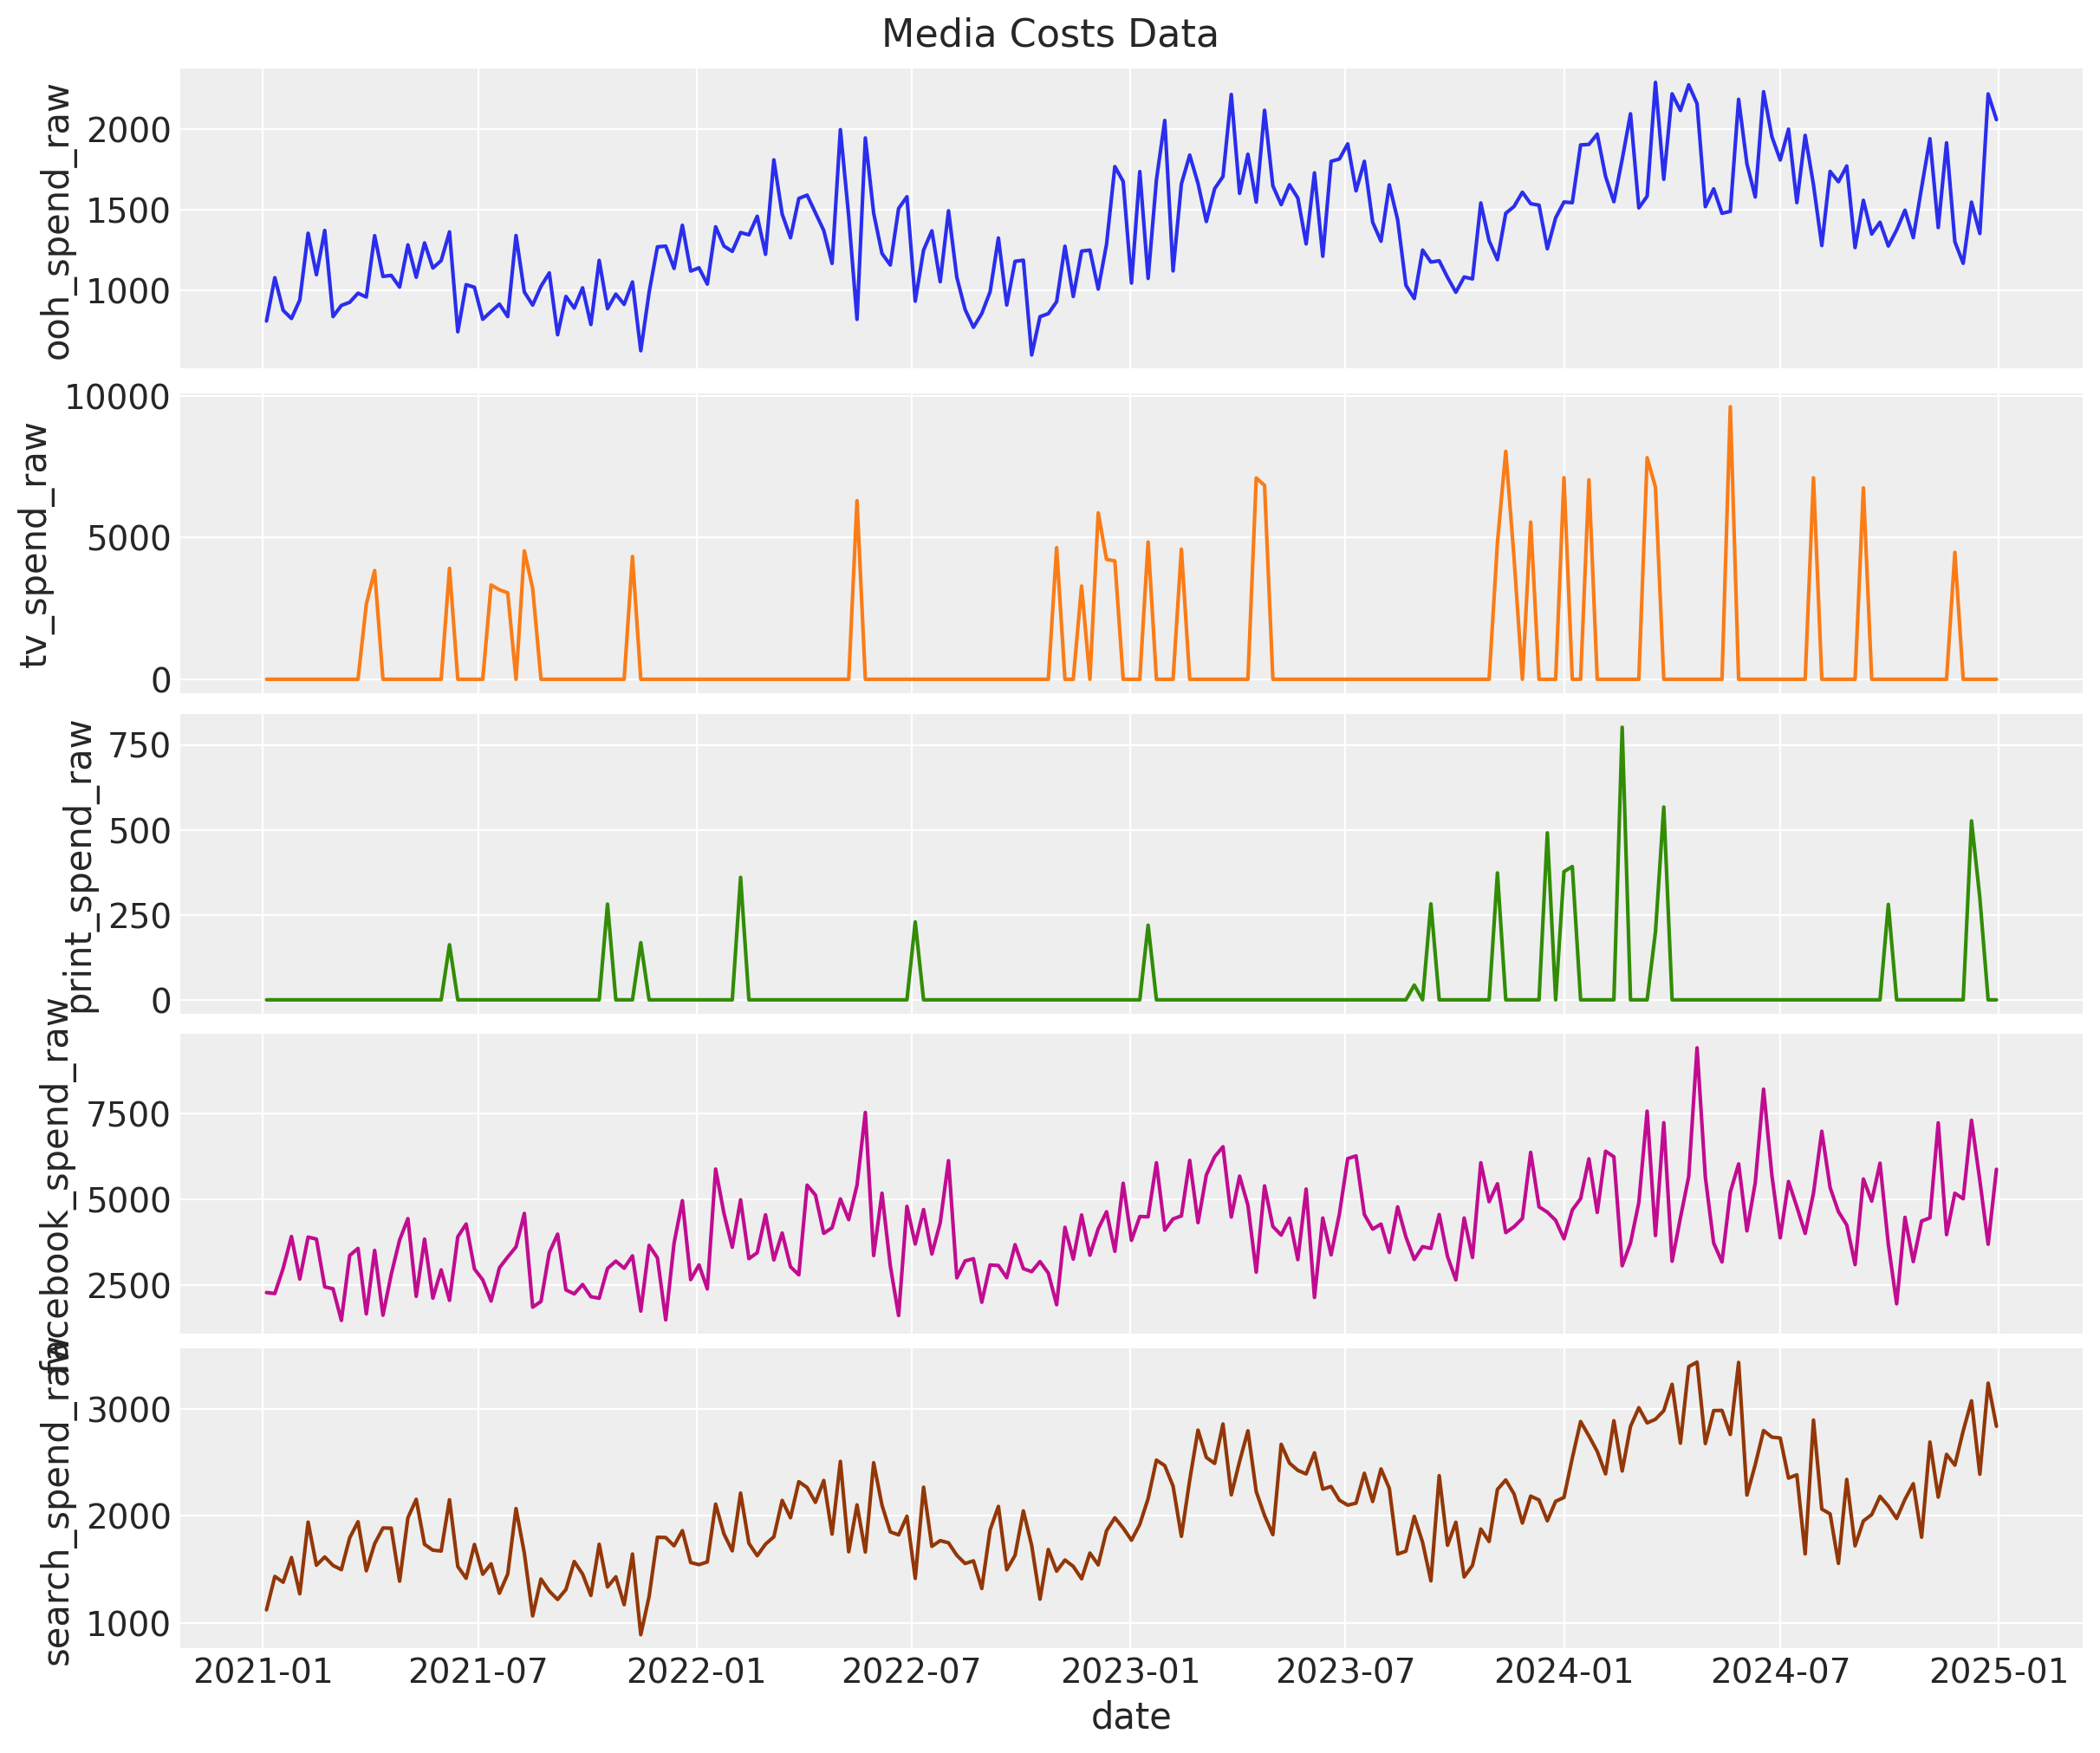

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 10), sharex=True, sharey=False)
sns.lineplot(x="date", y="ooh_spend_raw", data=df, ax=ax[0],color="C0")
sns.lineplot(x="date", y="tv_spend_raw", data=df,  ax=ax[1],color="C1")
sns.lineplot(x="date", y="print_spend_raw", data=df,  ax=ax[2],color="C2")
sns.lineplot(x="date", y="facebook_spend_raw", data=df,  ax=ax[3],color="C3")
sns.lineplot(x="date", y="search_spend_raw", data=df, ax=ax[4],color="C4")
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16)

In [14]:
#Apply adstock transformation
adstock_alphas = {
    "ooh": 0.6,
    "tv": 0.7,
    "print": 0.3,
    "facebook": 0.25,
    "search": 0.05
}
for channel in channels:
  df[f"{channel}_adstock"] = geometric_adstock(
            x=df[f"{channel}_spend"].to_numpy(),
            alpha=adstock_alphas[channel],
            l_max=8, 
            normalize=True).eval().flatten()

#Apply saturation transformation
saturation_lambdas = {
    "ooh": 1.5,
    "tv": 1.0,
    "print": 2.5,
    "facebook": 1.0,
    "search": 3.0
}
for channel in channels:
  lam = saturation_lambdas[channel]
  df[f"{channel}_saturated"] = logistic_saturation(x=df[f"{channel}_adstock"].to_numpy(), lam=lam).eval()


| Channel    | Type                  |alpha                | Justification                                                       |
| ---------- | --------------------- | ------------------- | ------------------------------------------------------------------- |
| `tv`       | Offline, mass media   | **0.5 – 0.8**       | Strong long-term effect (brand awareness, memorability)             |
| `ooh`      | Offline, visual       | **0.4 – 0.7**       | Moderately lasting impact, repeated exposure in public spaces       |
| `print`    | Offline, print media  | **0.2 – 0.5**       | Lower memorability, short-lived effect, rarely drives direct action |
| `facebook` | Digital, paid social  | **0.1 – 0.4**       | Short-term performance focus, quick decay of impact                 |
| `search`   | Digital, intent-based | **0.0 – 0.2**       | No carryover effect: impact is immediate (direct response channel)  |


| Channel    | Type                  |              λ             | Justification                                                                      |
| ---------- | --------------------- | -------------------------- | ---------------------------------------------------------------------------------- |
| `tv`       | Offline, mass media   | **0.5 – 1.5**              | Strong saturation: TV reach saturates quickly (broad audience)                     |
| `ooh`      | Offline, visual       | **1.0 – 2.0**              | Moderate saturation, especially in high-exposure urban areas                       |
| `print`    | Offline, print media  | **1.5 – 3.0**              | Low saturation (narrow audience); hard to reach saturation point                   |
| `facebook` | Digital, paid social  | **0.5 – 1.5**              | Can saturate fast with high budget, algorithmically optimized                      |
| `search`   | Digital, intent-based | **2.0 – 4.0**              | Very low saturation: conversion effectiveness remains linear longer (pull channel) |


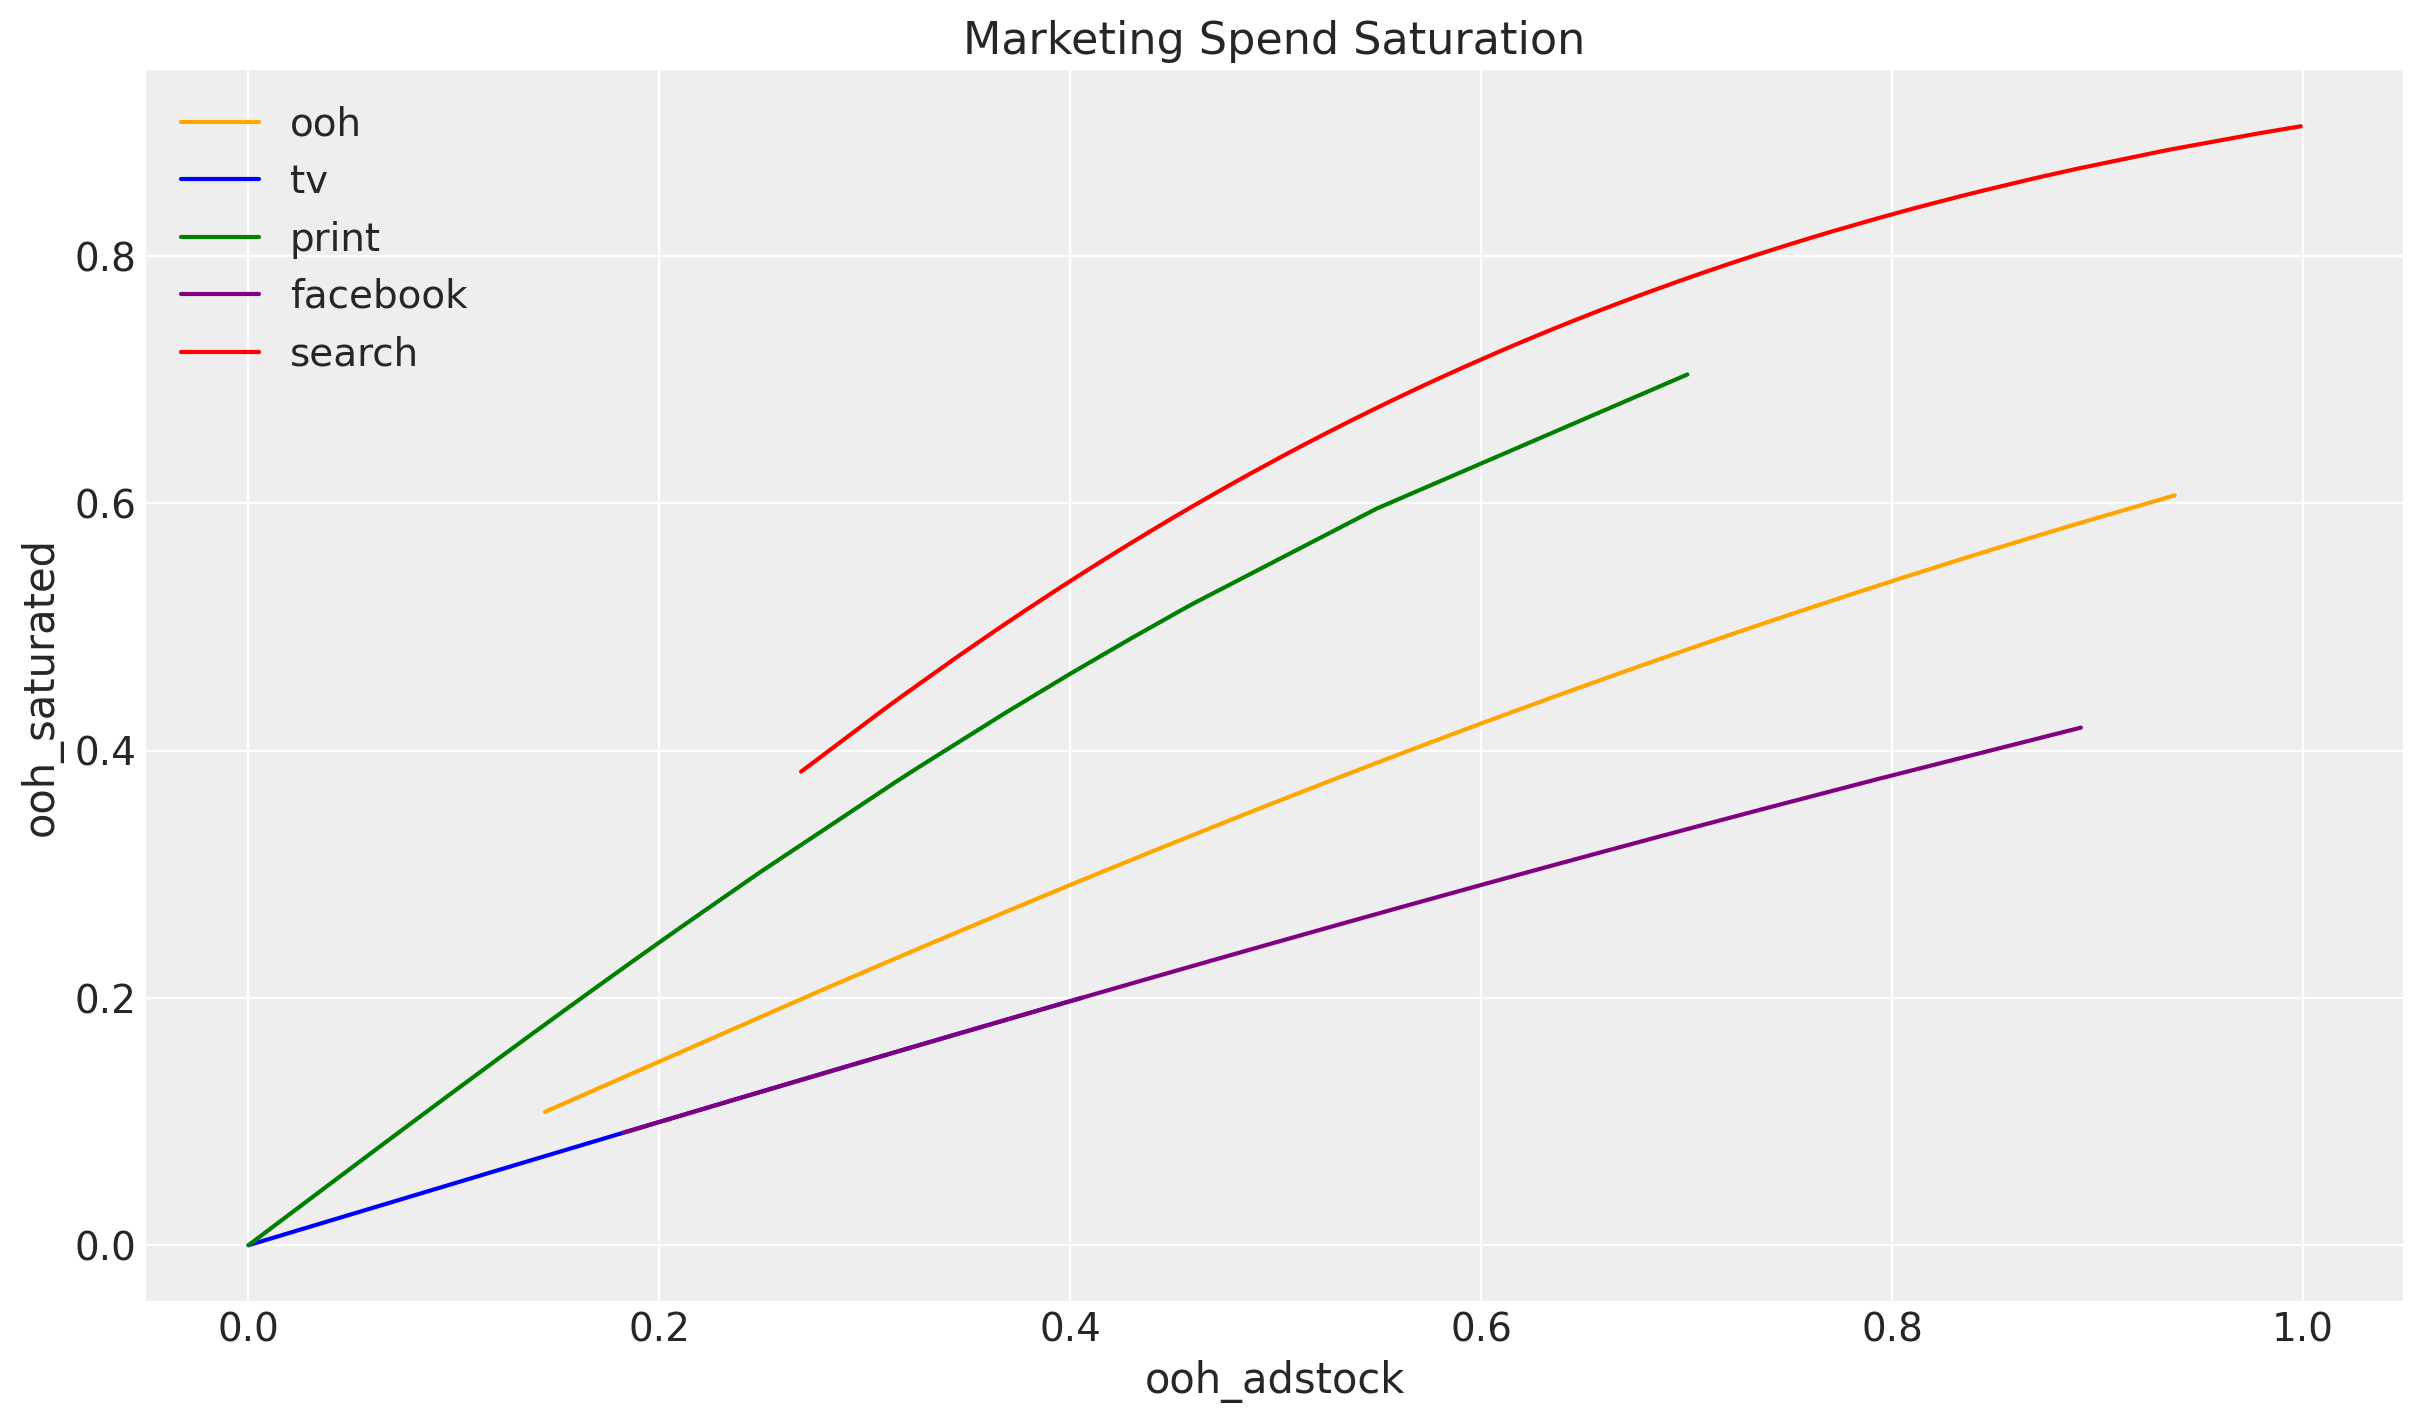

In [15]:
sns.lineplot(x=df['ooh_adstock'], y=df['ooh_saturated'], label=channels[0], color="orange")
sns.lineplot(x=df['tv_adstock'], y=df['tv_saturated'], label=channels[1], color="blue")
sns.lineplot(x=df['print_adstock'], y=df['print_saturated'], label=channels[2], color="green")
sns.lineplot(x=df['facebook_adstock'], y=df['facebook_saturated'], label=channels[3], color="purple")
sns.lineplot(x=df['search_adstock'], y=df['search_saturated'], label=channels[4], color="red")
plt.title('Marketing Spend Saturation', fontsize=16)
plt.legend()
plt.show()

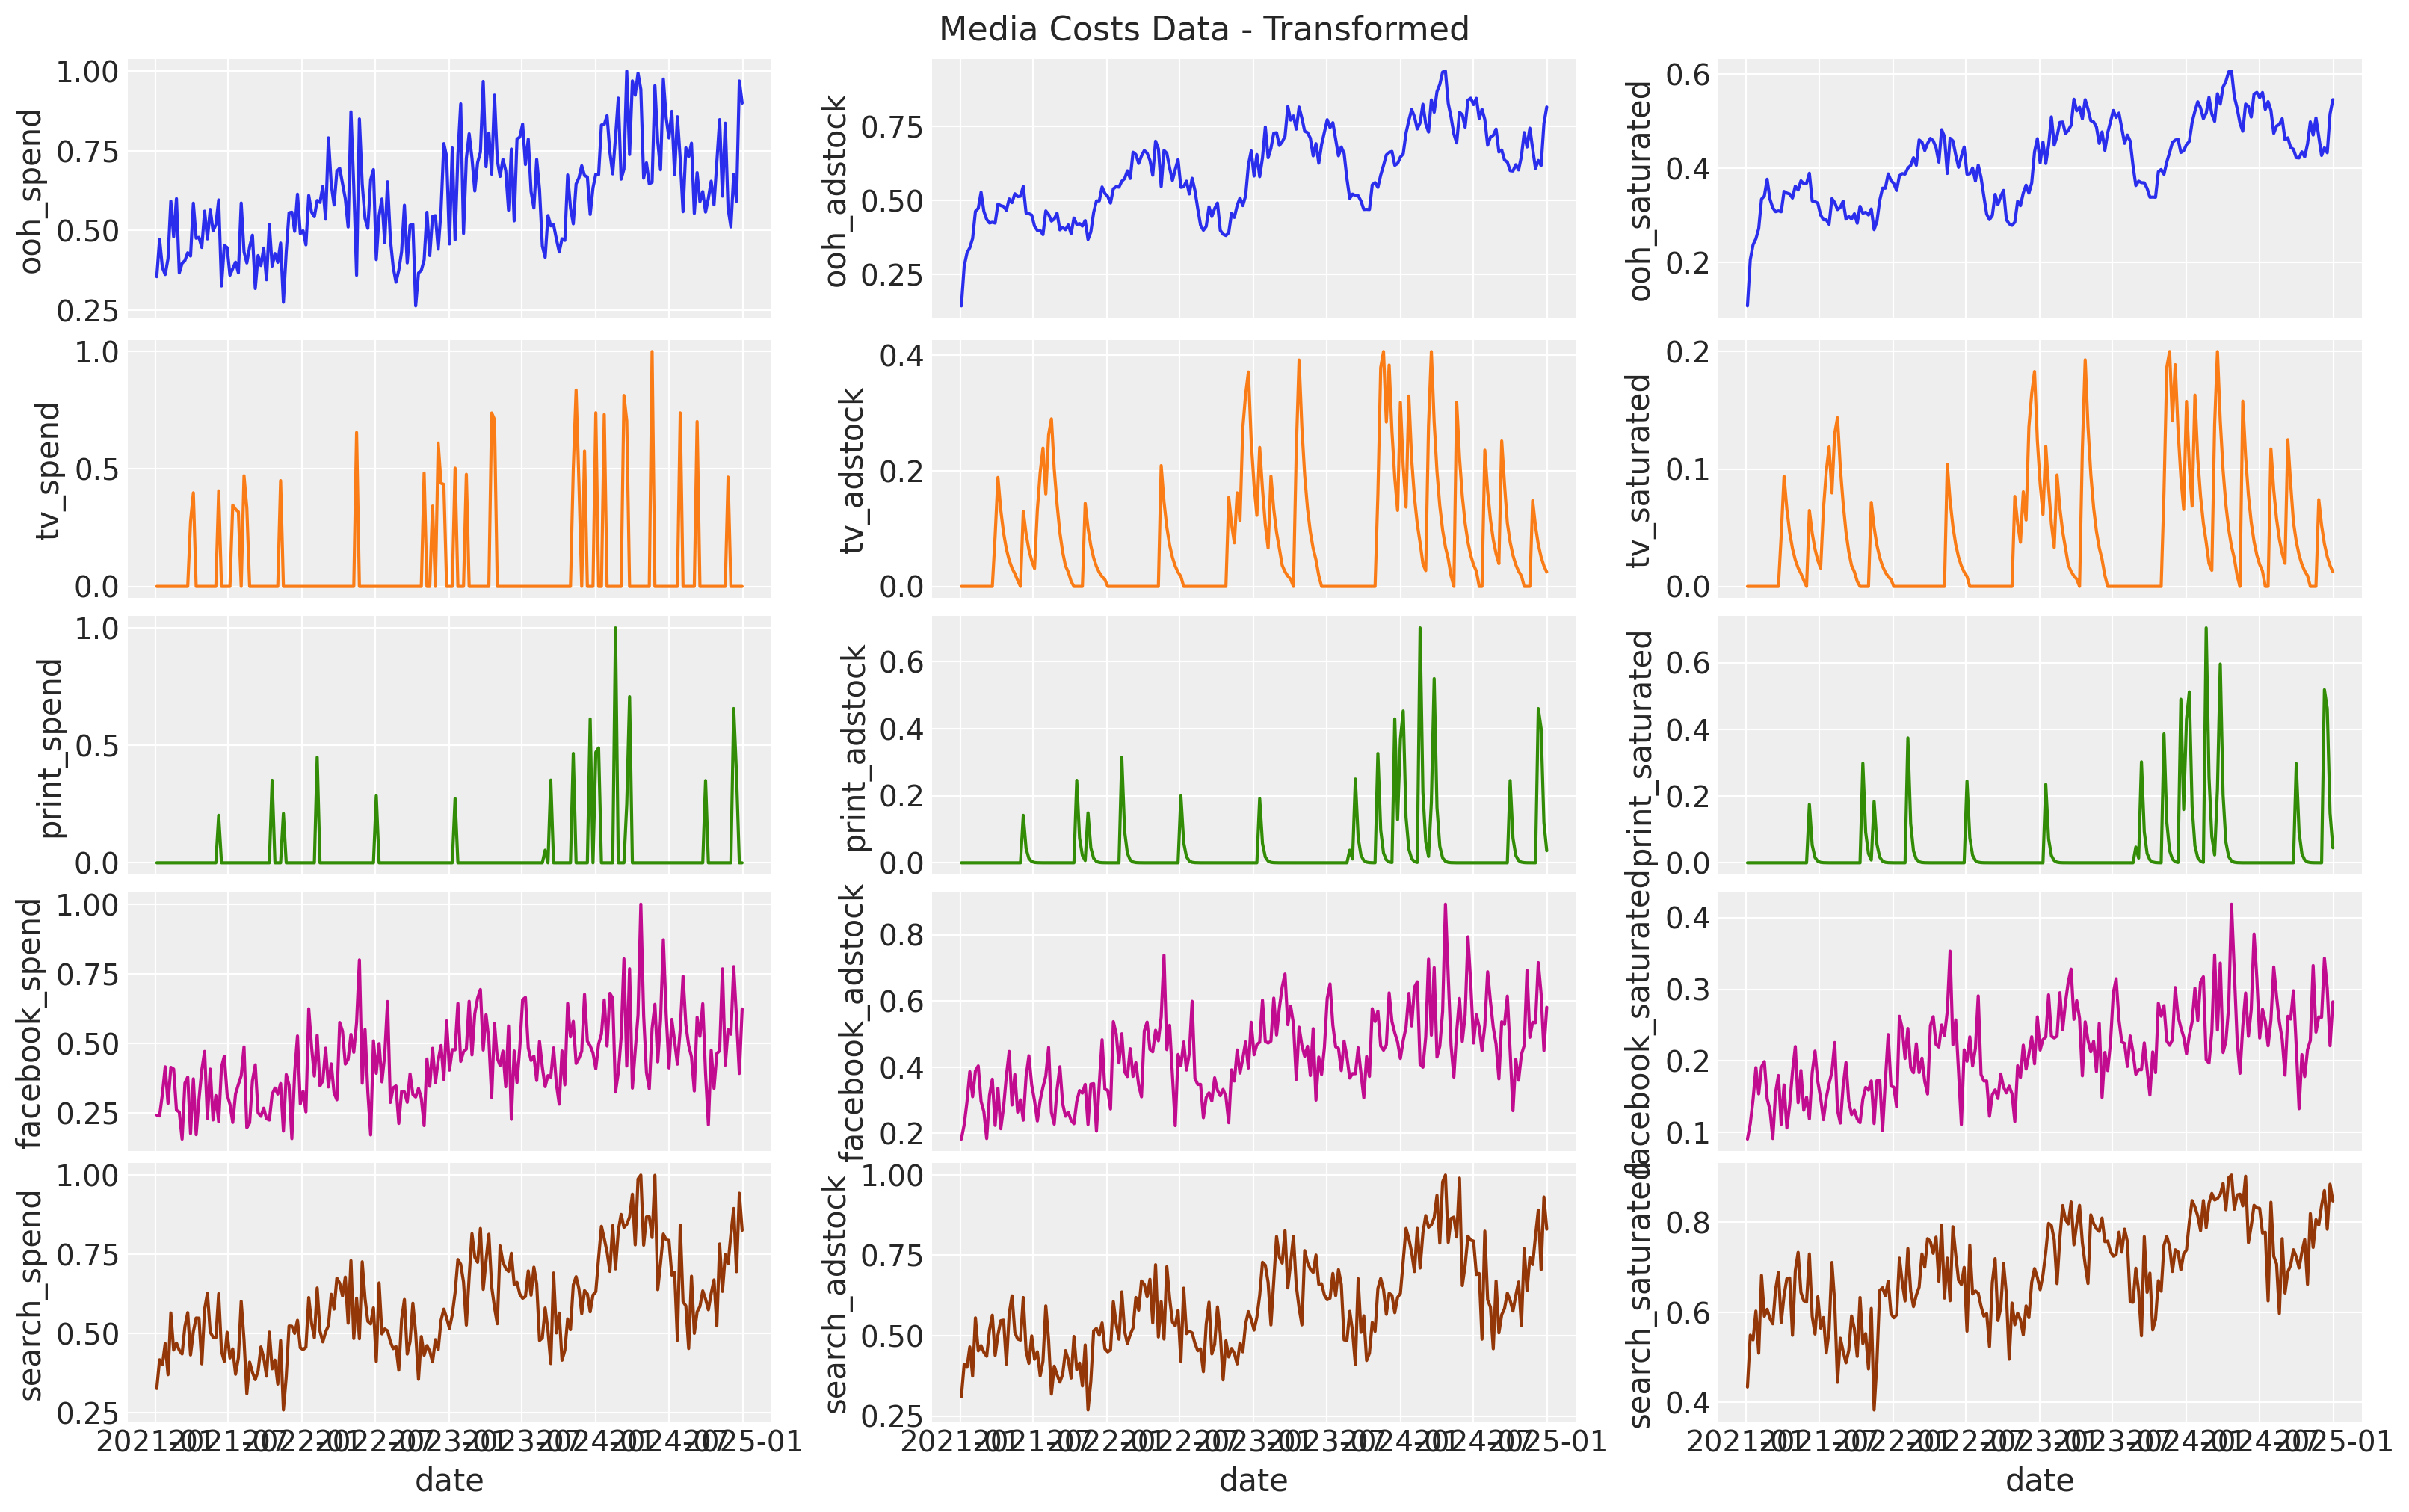

In [16]:
fig, ax = plt.subplots(5,3,figsize=(16, 10),sharex=True,sharey=False,layout="constrained")
color=["C0", "C1", "C2", "C3", "C4"]
for i, channel in enumerate(channels):    
    # Tracé des 3 courbes : raw, adstocked, saturated
    sns.lineplot(x="date", y=f"{channel}_spend", ax=ax[i,0], data=df,color=color[i])
    sns.lineplot(x="date", y=f"{channel}_adstock", ax=ax[i,1], data=df,color=color[i])
    sns.lineplot(x="date", y=f"{channel}_saturated", ax=ax[i,2], data=df,color=color[i])
 
fig.suptitle("Media Costs Data - Transformed", fontsize=16)
plt.show()

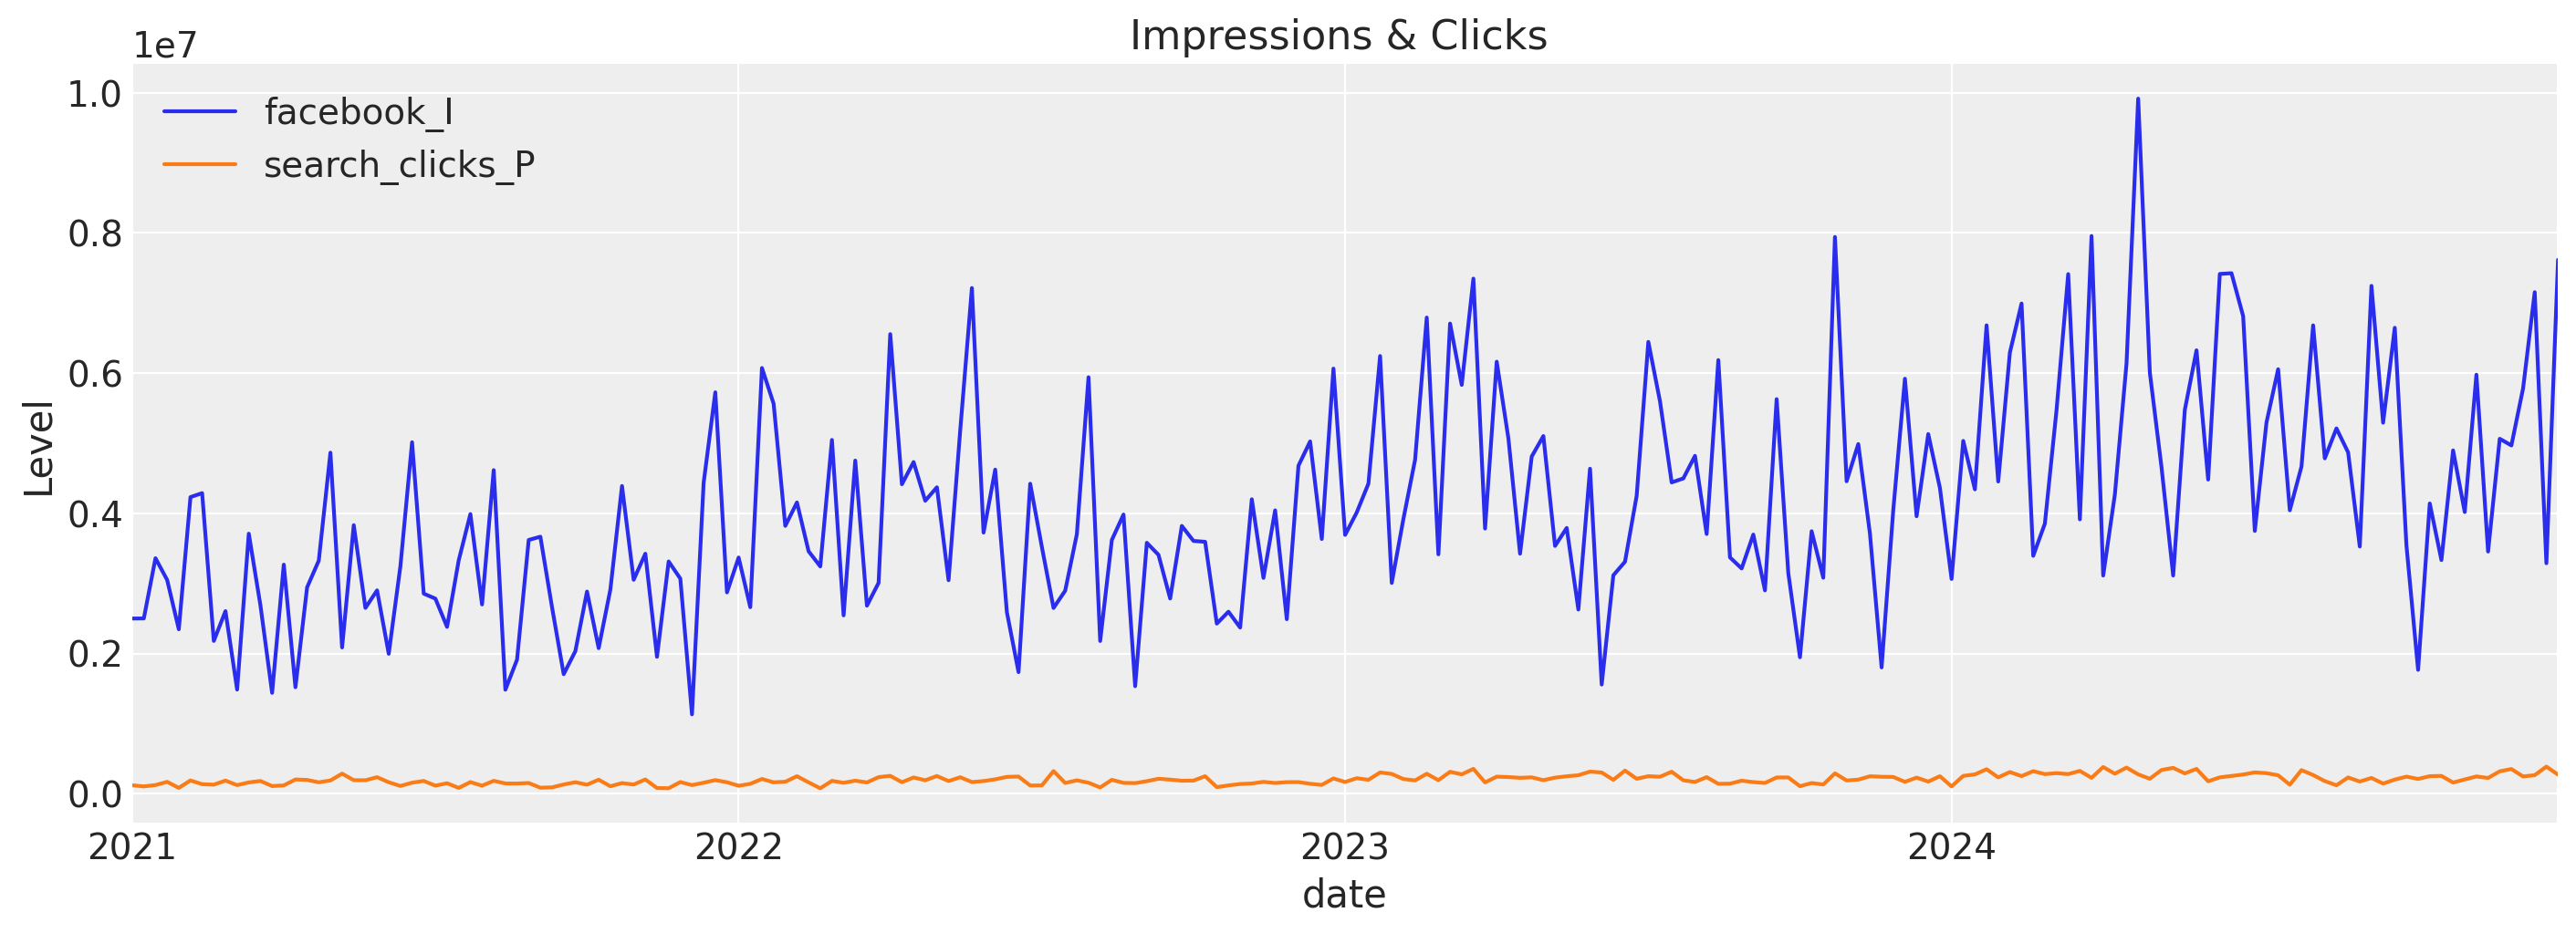

In [17]:
# Facebook Impressions 
df["facebook_I"] = df["facebook_spend_raw"] * rng.normal(loc=1000, scale=150, size=n)
df["facebook_I"] = np.clip(df["facebook_I"], 0, None)  # only positive impressions

# Search Clicks (Google search ads performance)
df["search_clicks_P"] = df["search_spend_raw"] * rng.normal(loc=100, scale=20, size=n)
df["search_clicks_P"] = np.clip(df["search_clicks_P"], 0, None)


df[["date", "facebook_I", "search_clicks_P"]].plot(x="date", figsize=(14, 5), title="Impressions & Clicks ")
plt.ylabel("Level")
plt.show()


5. Control Variable

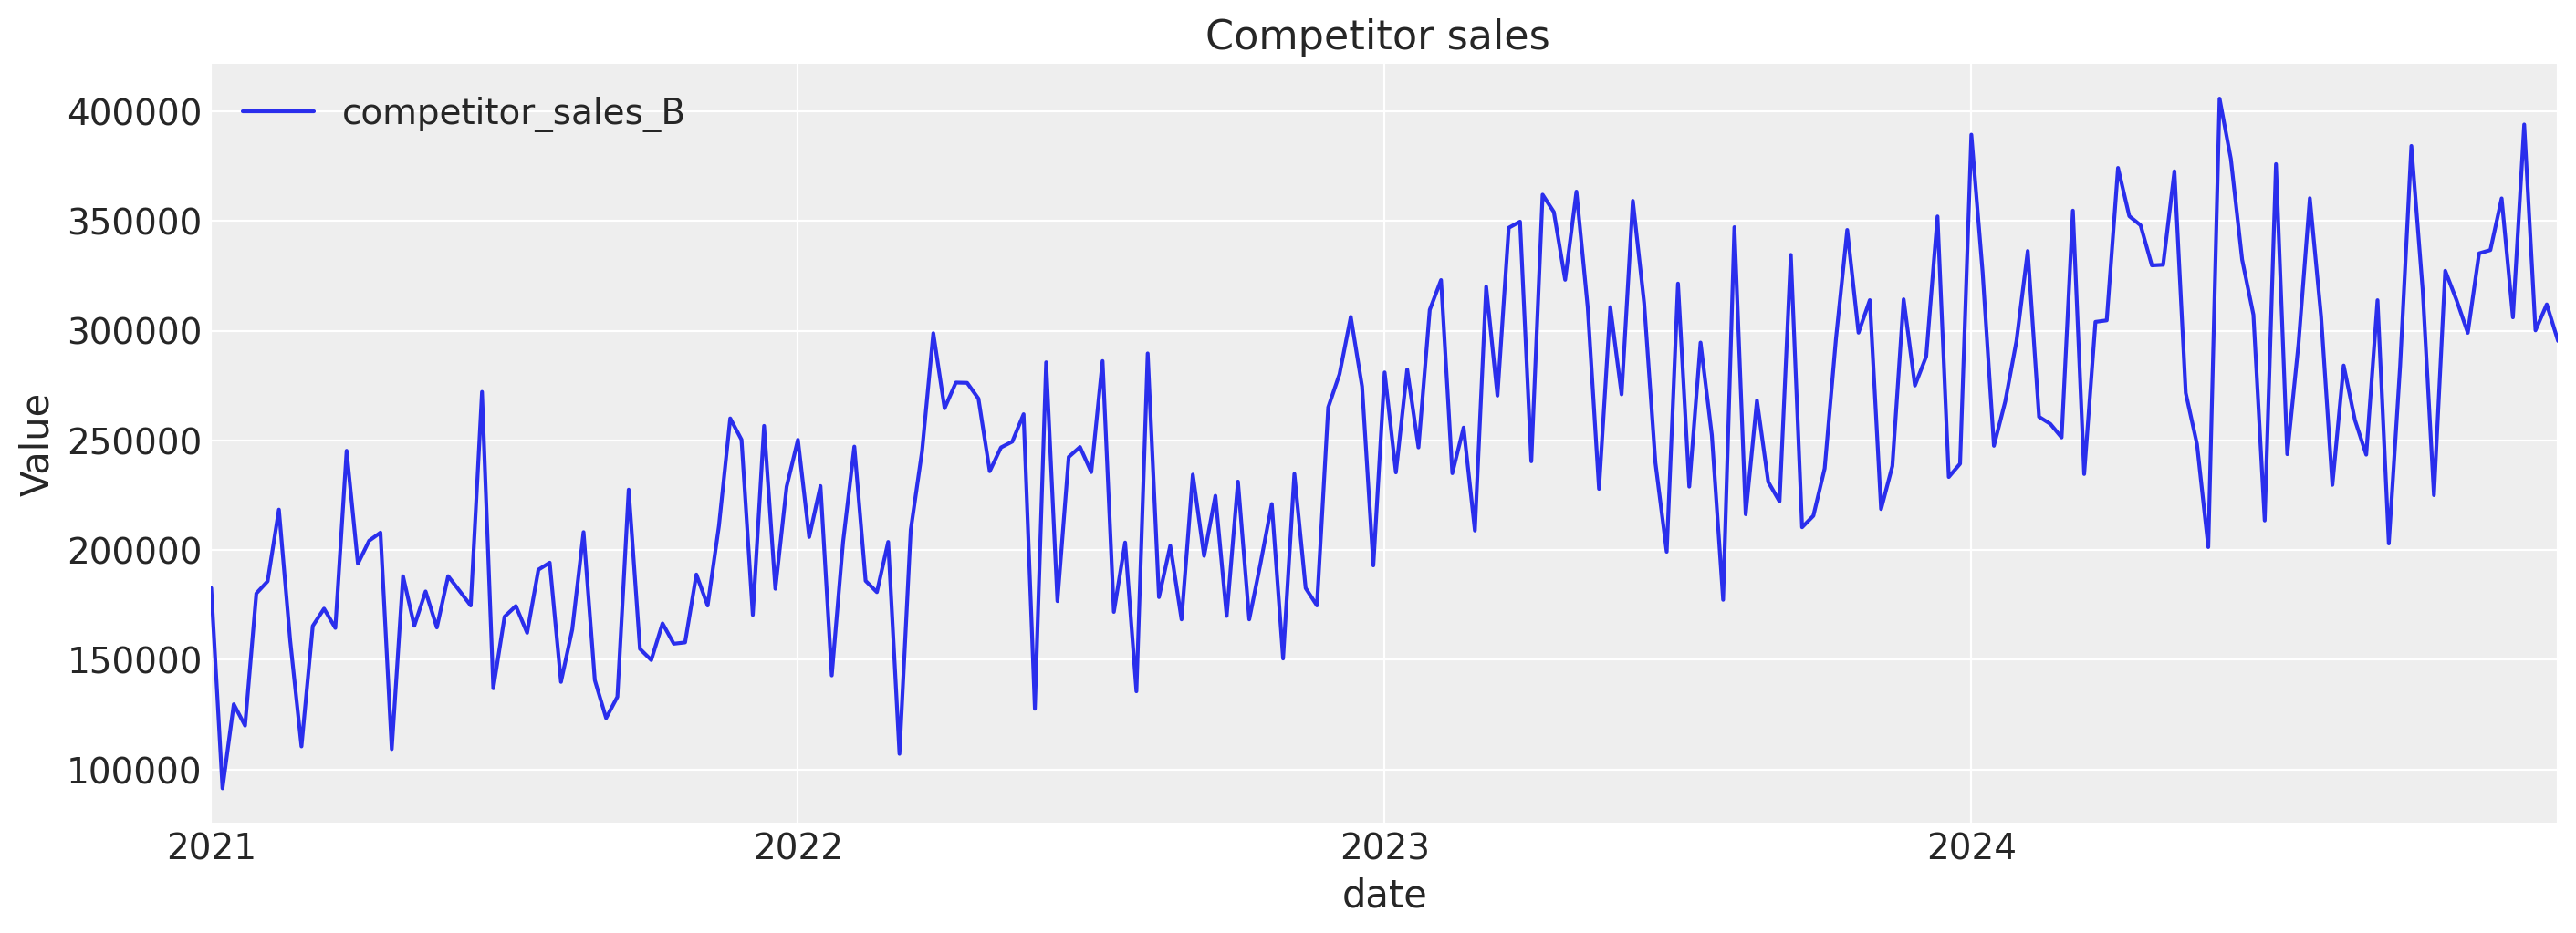

In [18]:
# Competitor sales baseline 
competitor_noise = rng.normal(loc=1.0, scale=0.2, size=n)
df["competitor_sales_B"] = ((df["trend"] * (1 + 0.5 * df["seasonality"])) * 70000 * competitor_noise)
df[["date", "competitor_sales_B"]].plot(x="date", figsize=(14, 5), title="Competitor sales ")
plt.ylabel("Value")
plt.show()

In [19]:
# Optional: scale control variable and digital metrics
df["competitor_sales_B_scaled"] = MaxAbsScaler().fit_transform(df[["competitor_sales_B"]])
df["facebook_I_scaled"] = MaxAbsScaler().fit_transform(df[["facebook_I"]])
df["search_clicks_P_scaled"] = MaxAbsScaler().fit_transform(df[["search_clicks_P"]])


6. Target variable

We assume it is a linear combination of the effect signal, the trend and the seasonal components, plus the two events and an intercept. We also add some Gaussian noise.

| Channel    | Suggested `beta` | Reasoning                                              |
| ---------- | ---------------- | ------------------------------------------------------ |
| `tv`       | **0.8**          | TV is good for awareness, but effect is slow/indirect  |
| `ooh`      | **0.6**          | Reinforces brand, but not action-driving               |
| `print`    | **0.3**          | Very limited performance role today                    |
| `facebook` | **1.2**          | High conversion potential, algorithmic targeting       |
| `search`   | **2.0**          | Highest sales-driving potential, matches active intent |


In [20]:
betas = {
    "ooh": 0.6,
    "tv": 0.8,
    "print": 0.3,
    "facebook": 1.2,
    "search": 2.0
}
#Initialize sales based on demand
df["sales"] = df["demand"]

for channel in channels:
  # Calculate contribution to sales
  df[f"{channel}_sales"] = df[f"{channel}_saturated"] * betas[channel]
  # Add the channel-specific contribution to sales
  df["sales"] += df[f"{channel}_sales"]

# Add competitor effect
competitor_beta = -0.3
df["sales"] += competitor_beta * df["competitor_sales_B"]

# Add impressions and clicks effect
impressions_beta = 0.0001   
clicks_beta = 0.01
df["sales"] += impressions_beta * df["facebook_I"]
df["sales"] += clicks_beta * df["search_clicks_P"]

#Add noise to sales
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)
df["sales"] += df["epsilon"]


C:\Users\okouo\AppData\Local\Temp\ipykernel_19968\117295854.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


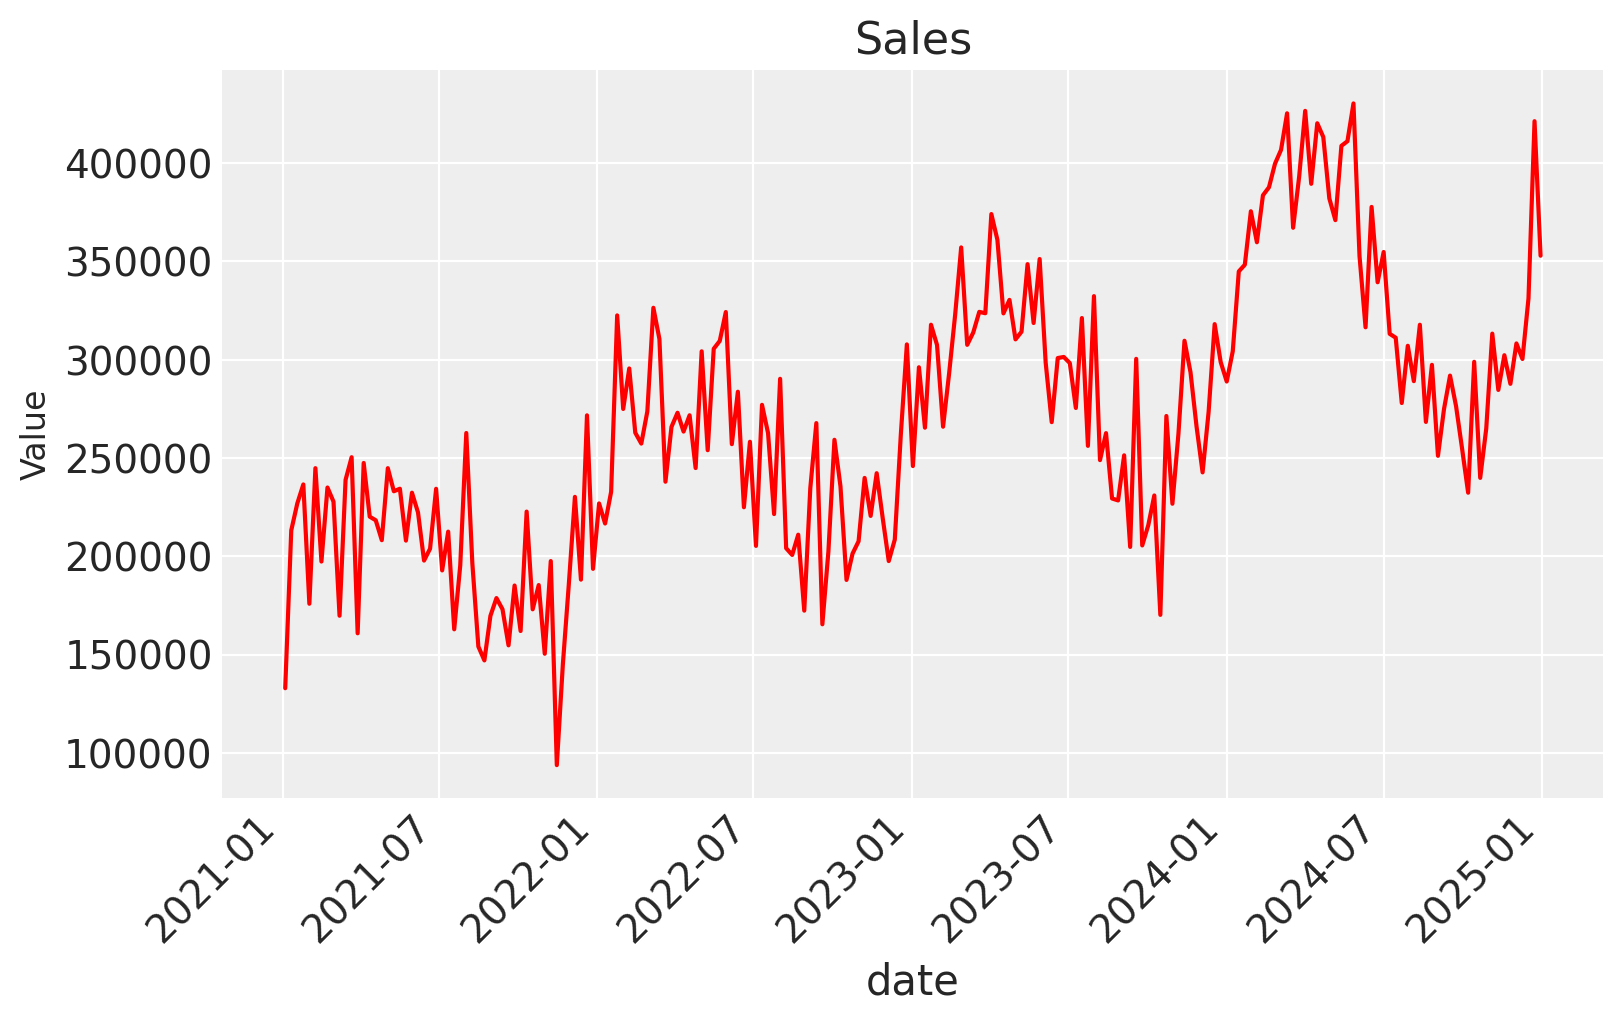

In [21]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['sales'], color="red")

plt.title('Sales', fontsize=16)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [22]:
df.to_csv("data.csv")